In [1]:
import gym
import random, math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
from reinforce_rwd2go import reinforce_rwd2go, rollout, make_pref_dataset
from utils import pref_save, pref_load

from model import getPolicy
import pickle

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'CartPole-v0'

env = gym.make(ENV_NAME)

K = 1000

/opt/anaconda3/envs/mnlp_exercises/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/opt/anaconda3/envs/mnlp_exercises/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/envs/mnlp_exercises/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
from reinforce_rwd2go import reinforce_rwd2go_2

policy = getPolicy(ENV_NAME=ENV_NAME).to(device)
opt = optim.Adam(policy.parameters(), lr=1e-2)

print("=== Training π₁ to get π₁ and π₂ ===")
scores = reinforce_rwd2go_2(env, policy, opt, env, n_episodes=2000, print_every=100, near_max_reward=195)


=== Training π₁ to get π₁ and π₂ ===


/opt/anaconda3/envs/mnlp_exercises/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Half target policy saved at ep 62 (reward=133.0, avg=32.6)
Half target policy saved at ep 91 (mean reward over 10 last ep =101.2, avg=46.1)
Ep 100	avg100: 56.87
Ep 200	avg100: 173.63
Reached converged policy to max reward at ep 266 (avg=196.5)


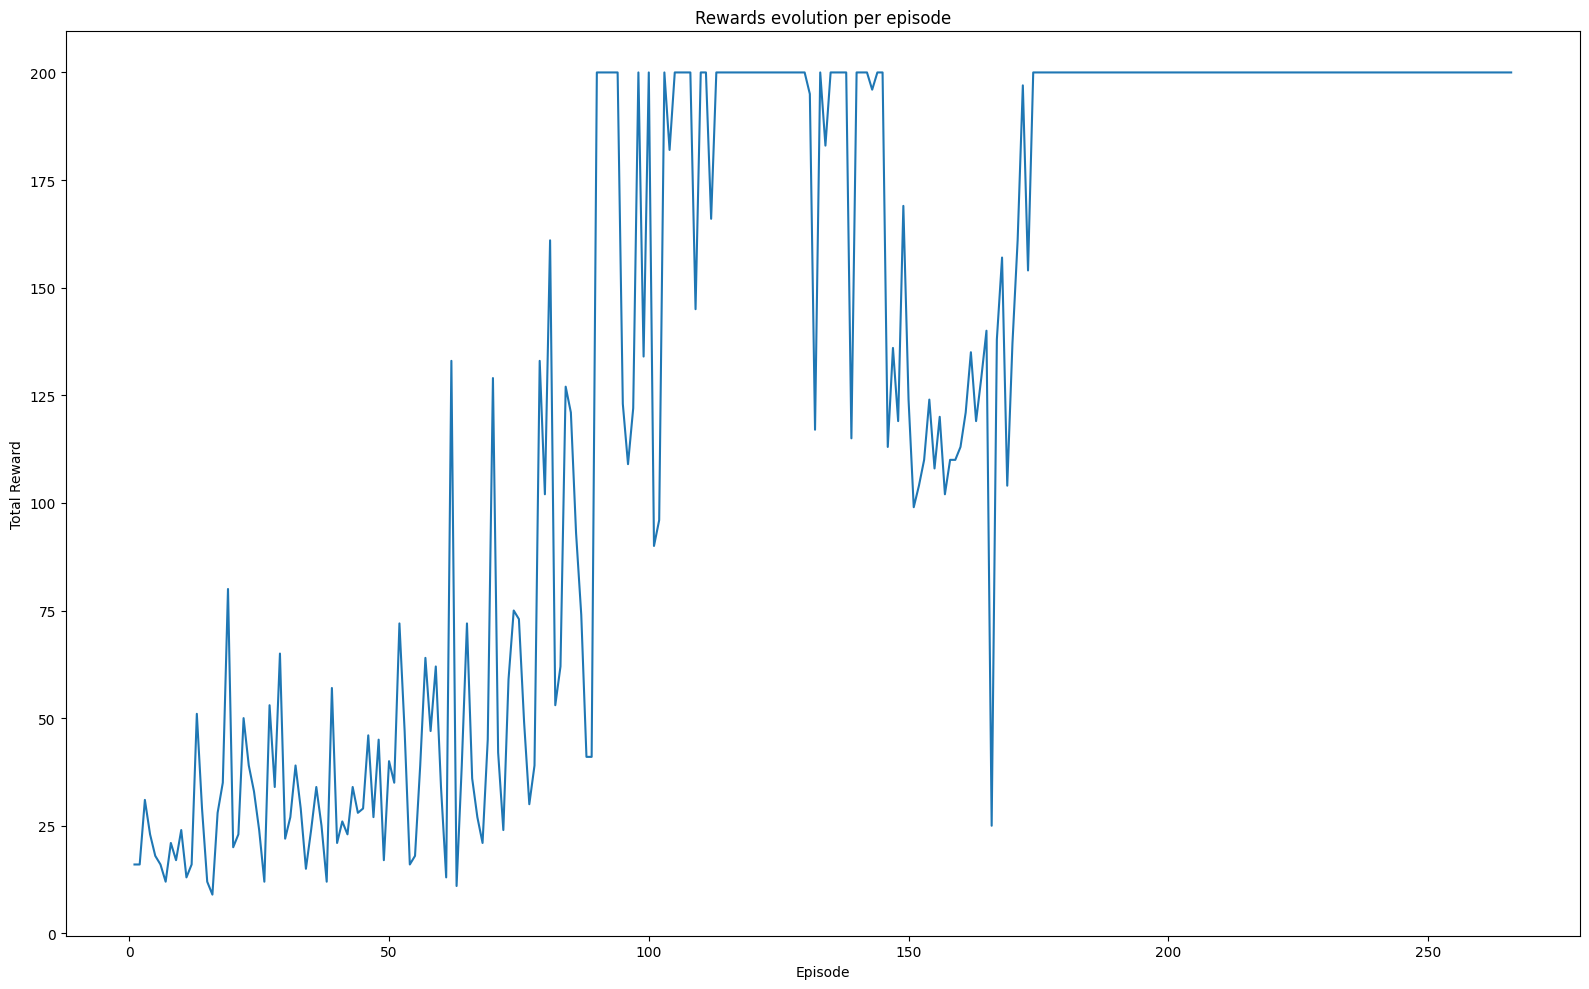

In [6]:
import matplotlib.pyplot as plt

def plot_rewards(scores, window=100):
    episodes = list(range(1, len(scores) + 1))

    plt.figure()
    plt.plot(episodes, scores)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Rewards evolution per episode")
    plt.tight_layout()
    plt.show()

plot_rewards(scores)

In [ ]:
policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
opt1    = optim.Adam(policy1.parameters(), lr=1e-2)

print("=== Training π₁ ===")
scores1 = reinforce_rwd2go(env, policy1, opt1, env,
                            n_episodes=2000, print_every=100,
                            target_reward=None, near_max_reward=195, gamma=0.95)
avg1 = np.mean(scores1[-100:])
print(f"Final π₁ avg100: {avg1:.2f}\n")

In [62]:
policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
opt2    = optim.Adam(policy2.parameters(), lr=1e-2)
half_target = avg1 / 2.0

print("=== Training π₂ ===")
scores2 = reinforce_rwd2go(env, policy2, opt2, env,
                            n_episodes=2000, print_every=100,
                            target_reward=half_target, near_max_reward=195)
avg2 = np.mean(scores2[-100:])
print(f"Final π₂ avg100: {avg2:.2f}\n")

=== Training π₂ ===
Ep 100	avg100: 45.97
Reached target 97.7 at ep 104 (avg=48.1)
Final π₂ avg100: 48.11



In [63]:

print(f"Generating {K} preference pairs …")
pref_data = make_pref_dataset(policy1, policy2, env, K)
pref_save(pref_data, f"pref_data_{K}_{ENV_NAME}.pickle")
print("Finished")

torch.save(policy1.state_dict(), f"policy1_{K}_{ENV_NAME}.pth")
torch.save(policy2.state_dict(), f"policy2_{K}_{ENV_NAME}.pth")

Generating 1000 preference pairs …
Mean p1 199.793
Mean p2 72.225
Finished
